In [88]:
import preprocess as prep
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

sns.set_theme()    # set plot theme

def suppress_warning():
    warnings.filterwarnings('ignore')

suppress_warning()

PATH_FILE = prep.PATH_FILE_NAME  # unique paths and number of inputs on that path
X_FILE = prep.X_FILE_NAME        # file of inputs, e.g. png inputs
Y_FILE = prep.Y_FILE_NAME        # uncompressed: 'y_orig' and compressed bitmap: 'y_compress'



In [5]:
def sort_path_by_num_of_inputs(mat_path, path_count):
    idx = np.argsort(path_count)[::-1]
    return mat_path[idx, :], path_count[idx]

def read_np_data(x_file_name, y_file_name, path_file_name):
    """ read data from numpy file """
    x_file = np.load(x_file_name)
    y_file = np.load(y_file_name)
    path_file = np.load(path_file_name)
    x = x_file['x']
    y = y_file['y_compress']
    path = path_file['path']
    count_inputs_by_path = path_file['input_count']
    # path, count_inputs_by_path = sort_path_by_num_of_inputs(path, count_inputs_by_path)
    return x, y, path, count_inputs_by_path

x, y, path, count_inputs_by_path = read_np_data(X_FILE, Y_FILE, PATH_FILE)

# 1. Inpect Paths

Each path is a compressed bitmap, e.g., bytes that are zero in all input bitmaps are trimmed.

Each row of `path` repesent a unique bitmap with dimmension $2149$, there are $699$ paths in total.


In [3]:
print(f"(num-of-paths, dim-of-path-bitmap): {path.shape}")

(num-of-paths, dim-of-path-bitmap): (699, 2194)



_the total path AFL recognises is_ $319$

the AFL screenshot:

```

                      american fuzzy lop 2.57b (pngimage)

┌─ process timing ─────────────────────────────────────┬─ overall results ─────┐
│        run time : 0 days, 0 hrs, 1 min, 53 sec       │  cycles done : 0      │
│   last new path : 0 days, 0 hrs, 0 min, 3 sec        │  total paths : 319    │
│ last uniq crash : none seen yet                      │ uniq crashes : 0      │
│  last uniq hang : none seen yet                      │   uniq hangs : 0      │
├─ cycle progress ────────────────────┬─ map coverage ─┴───────────────────────┤
│  now processing : 2 (0.63%)         │    map density : 2.19% / 4.20%         │
│ paths timed out : 0 (0.00%)         │ count coverage : 3.30 bits/tuple       │
├─ stage progress ────────────────────┼─ findings in depth ────────────────────┤
│  now trying : arith 8/8             │ favored paths : 73 (22.88%)            │
│ stage execs : 5896/12.8k (46.13%)   │  new edges on : 109 (34.17%)           │
│ total execs : 111k                  │ total crashes : 0 (0 unique)           │
│  exec speed : 1163/sec              │  total tmouts : 0 (0 unique)           │
├─ fuzzing strategy yields ───────────┴───────────────┬─ path geometry ────────┤
│   bit flips : 146/4832, 17/4830, 9/4826             │    levels : 2          │
│  byte flips : 3/604, 4/520, 7/528                   │   pending : 318        │
│ arithmetics : 40/17.4k, 2/5895, 0/2880              │  pend fav : 73         │
│  known ints : 8/1658, 9/7538, 1/12.9k               │ own finds : 315        │
│  dictionary : 0/0, 0/0, 34/5822                     │  imported : n/a        │
│       havoc : 22/32.8k, 0/0                         │ stability : 100.00%    │
│        trim : 0.00%/271, 14.47%                     ├────────────────────────┘
├─────────────────────────────────────────────────────┘          [cpu001: 50%]
```

## 1.1 Grouping / Distance of the paths

We first try to inspect the paths by calculating the ___Pearson Correlation___ of paths. 

Let $x, y \in F^n$, the correlation is defined as 

$$
    r_{xy} = \frac{\sum (x_i - \bar{x})(y_i-\bar{y})}{\|x-\bar{x}\| \cdot \|y-\bar{y}\|}
$$

it can be also treated as the **cosine similarity**.

In [41]:
def plot_path_similarity(mat_path, path_count):
    """
    calculate and plot the cosine similarity of the paths.
    the paths are sorted descending by the number of inputs on that path

    left subplot: similarity considering hitting times on each edge
    right subplot: 
    """
    corr_path = np.corrcoef(mat_path, rowvar=True)
    corr_flag_path = np.corrcoef(mat_path > 0, rowvar=True) # igore hitting times on edges

    grid_row = 5
    grid_col = 2 * (grid_row - 1) + 1
    figure = plt.figure(constrained_layout=True)
    gs = figure.add_gridspec(grid_row, grid_col)
    ax1 = figure.add_subplot(gs[:(grid_row - 1), :(grid_col // 2)])
    ax1.matshow(corr_path)
    ax2 = figure.add_subplot(gs[:(grid_row - 1), (grid_col // 2 + 1):])
    ax2.matshow(corr_flag_path)
    ax3 = figure.add_subplot(gs[-1, :(grid_col // 2)])
    smoothed_path_count = np.convolve(path_count, np.ones(1), mode='same')
    ax3.plot(smoothed_path_count)
    ax4 = figure.add_subplot(gs[-1, (grid_col // 2 + 1):])
    ax4.plot(smoothed_path_count)
    figure.show()


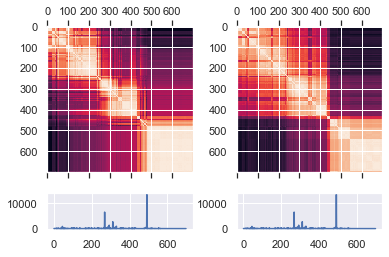

In [48]:
plot_path_similarity(path, count_inputs_by_path)

The upper 2 subgraphs plot the the cosine similarity of these paths.
as the brighter the position $(i, j)$ is, the similarer `path[i]` and `path[j]` is.

The lower 2 subgraph plots the number of inputs that run through the path.



### Obervation

we observe that pathes are grouped.

Can we define the degree of interesting of an input using the its predicted path?

Let $P$ be the set of paths and $\hat{p}_i$ be the predicted path of $i$,
 $\forall p \in P$ define $p$'s observation set $O_p$, i.e. inputs that runs through $p$.

we may define the reject probbiilty as 

$$
\Pr(\mathrm{reject} i) \propto \sum_{p\in P} w_p * \mathrm{corr}(\hat{p}_i, p)
$$

while

$$
w_p \propto |O_p|
$$

**_The idea is we can try to explore more unexploited paths_**


## 1.2 How inputs distributed over paths ?

The idea hear is we would like to see how inputs are concentrated.

If only a small number of paths takes the majority of inputs, we can target at those paths to filter out most inputs, e.g. if 90% of inputs that run through only a handful of paths we can just train our model targets to these hot paths.

**We may like to inspect the qantile of inputs and paths, 
    i.e., x% of inputs runs on y% of paths or y% of paths has x% of inputs.**


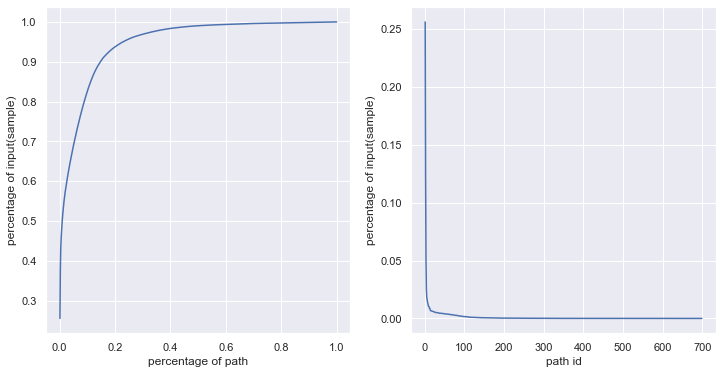

In [74]:
def qq_plot_input_path(path_count):
    sorted_count = np.sort(path_count)[::-1]
    input_quantile = sorted_count.cumsum() / path_count.sum()
    path_quantile = (np.arange(path_count.size) + 1) / path_count.size
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    # axs[0].plot(input_quantile, path_quantile)
    axs[0].plot(path_quantile, input_quantile)
    axs[0].set_xlabel("percentage of path")
    axs[0].set_ylabel("percentage of input(sample)")
    axs[1].plot(np.arange(path_count.size) + 1, sorted_count / sorted_count.sum())
    axs[1].set_xlabel("path id")
    axs[1].set_ylabel("percentage of input(sample)")
    fig.show()

qq_plot_input_path(count_inputs_by_path)


### Observation

- 25% of the inputs runs through the same path
- 80% of the inputs runs through 10% of the paths
- 95% of the inputs runs through 20% of the paths



The highest 20% most visited paths take about 75% of inputs, if we can predict on the 20% paths, the upper limit of the speedup is about 4

## 1.3 How many edges may a path contain?


In evarage, a path/input can visit 45.5% of edges


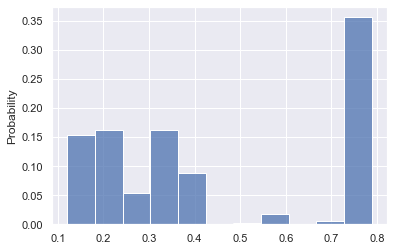

In [113]:
def path_dist_on_number_of_hitting_edges(mat_path):
    _, n_edge = mat_path.shape
    path_edge_count = np.sort((mat_path>0).sum(axis=1))[::-1]
    sns.histplot(path_edge_count / n_edge, stat="probability")
    print(f"In evarage, a path/input can visit { np.round(path_edge_count.mean() / n_edge *100,2)}% of edges")
path_dist_on_number_of_hitting_edges(path)

The x-axis of the bar plot is the persentage of edges a path hits, the y-axis stands for the proportion of paths in each bin.

- in varage, a path can visit 45.5% of edges
- about 35% of paths hits over 75% of edges
- about 30% of paths hits less than 25% of edges
- over 60% of paths hits less than 40% of edges.
- all paths can hit over 10% of the edges.


## 1.4 How many edges may an input hit?

In evarage, a path/input can visit 43.97% of edges


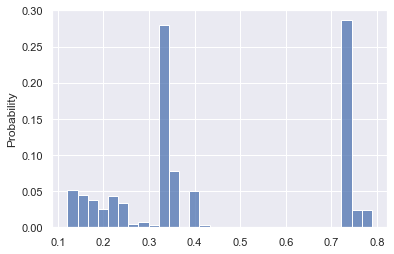

In [114]:
path_dist_on_number_of_hitting_edges(y)

# How edges are hit

This gives a hint of if we filter the inputs by targeting at some specific edges, whats the portion of inputs can we filter out.

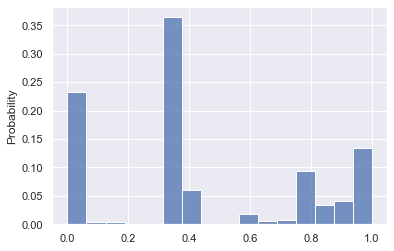

In [135]:
def count_inputs_by_edges(bitmaps):
    flag = bitmaps > 0
    count_by_edge = np.sort(flag.sum(axis=0))[::-1]
    n_input, _ = bitmaps.shape
    sns.histplot(count_by_edge / n_input, stat="probability")

count_inputs_by_edges(y)

x-axis is the percentage of input hit the edge, y-axis is the number of edges.
y-axis is the percentage of edges in the bin.

it can be seen from the graph:
- 13% of the edges are hit by nearly all of the inputs.
- over 30% of the edges are hit by more than 80% of inputs
- about 23% of the edges are only hit by a small portion of inputs (less than 10%)

The last observation is there is a largage portion of edges (about 23%) we can target at and filter out 90% of the inputs.